### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../')     # import path/to/synthpy

import src.simulator.config as config
config.jax_init()

import simulator.beam as beam_initialiser
import simulator.domain as d
import simulator.propagator as p
import processing.diagnostics as diag

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)
importlib.reload(diag)

Setting top level path for imports:/home/administrator/Work/UROP_ICL_Internship/synthPy/src

Disabling python multi-threading...

Initialising jax...

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


<module 'processing.diagnostics' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/src/processing/diagnostics.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [2]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

#n_cells = np.array([128, 100, 50])
n_cells = 128

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

#domain = d.ScalarDomain(x = x, y = y, z = z, extent = probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells, ne_type = "test_exponential_cos", debug = True, probing_direction = probing_direction) # B_on = False by default

# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

# only necessary to do so if you are not using the domain initialisation default distribution loading
# - that is the best option if using a test distribution

Predicted size in memory of domain: 8.0 MB

Free memory: 5.763820648193359 GB
Est. memory limit: 35.2 MB --> inc. +10% variance margin.

Coordinates have shape of (128, 128, 128) --> no padding required.

Generating test exponential decay periodic -e field...


Solve gradients, initialise beam, and solve

In [ ]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 300000    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

beam_definition = beam_initialiser.Beam(
    Np, beam_size, divergence, ne_extent,
    probing_direction = probing_direction,
    wavelength = lwl,
    beam_type = "circular"
)

# domain.dim - this causes a TracerBoolConversionError
# passing r_n all individually works though
# also passing ScalarDomain and extracting dim in p.solve(...) causes the same issue
# issue is due to unkown value when assigned to diffrax

rf, Jf, duration = p.solve(beam_definition.s0, domain, probing_extent)
# defaults: return_E = False, parallelise = True, jitted = True, save_steps = 2, memory_debug = False, lwl = 1064e-9, keep_domain = False


Size in memory of initial rays: 203.704833984375 MB

No need to generate any sections of the domain, batching not utilised.
 --> tracing to depth of 0.01 mm's

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('rows': 16, axis_types=(Auto,)), spec=PartitionSpec('rows', None), memory_kind=unpinned_host)

jax compilation of solver took: 0.00029969215393066406 seconds
Completed ray trace in 11.172001 seconds.

Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (300000, 2, 9)
 - 2 to account for the start and end results
 - 9 containing the 3 position and velocity components, amplitude, phase and polarisation
 - If batch_count is lower than expected, this is likely due to jax's forced integer batch sharding requirement over cpu cores.

We slice the end result and transpose into the form: (9, 300000) to work with later code.


Text(0, 0.5, 'e- density')

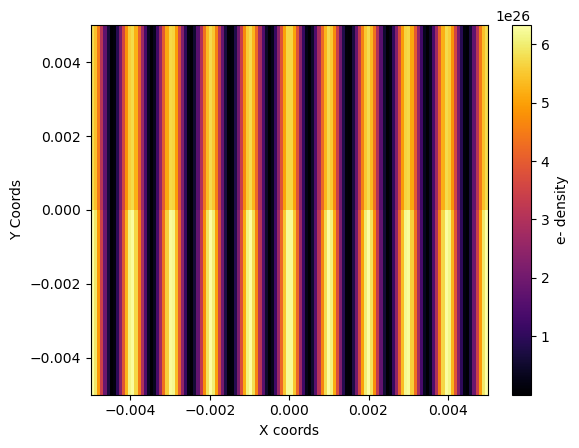

In [ ]:
xy = domain.ne[:, :, -1]

heatmap, ax = plt.subplots()

im = ax.imshow([xy[0], xy[1]], cmap='inferno', extent = [domain.x[0], domain.x[-1], domain.y[0], domain.y[-1]], interpolation='nearest', origin = 'lower', aspect = 'auto')
ax.set(xlabel='X coords', ylabel='Y Coords')

cbar = heatmap.colorbar(im)
cbar.ax.set_ylabel('e- density')

In [ ]:
#from diagnostics import m_to_mm
#rf_mm = m_to_mm(rf)

# this will btoh convert to mm and avoid unnecessary rays
refractometer = diag.Refractometry(lwl, rf)
rf_mm = refractometer.r0
del refractometer


300000 rays received, 195055 incident on the first lens.
 --> 35.0 % of rays wasted!



195055 rays received, 194273 incident on the first lens.
 --> 0.40100002 % of rays wasted!

rf size expected: [194273. 194273.]
rf after clearing nan's: [194273. 194273.]
(194273,) (194273,)


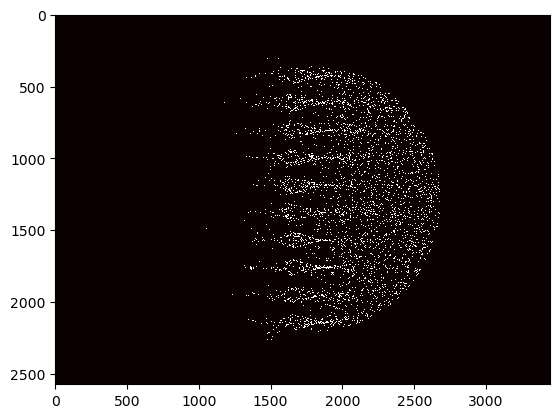

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf_mm)
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

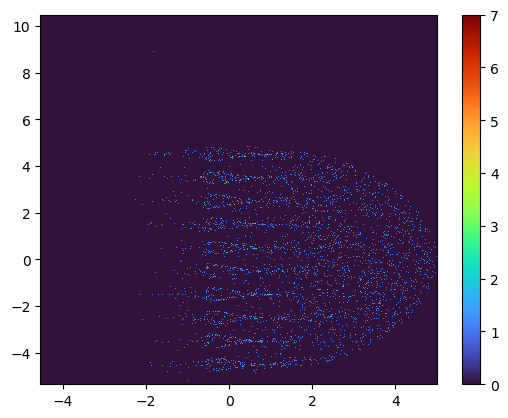

In [ ]:
from shared.utils import heat_plot
heat_plot(rf_mm[0], rf_mm[2])

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


300000 rays received, 195055 incident on the first lens.
 --> 35.0 % of rays wasted!

rf size expected: [195055. 195055.]
rf after clearing nan's: [195055. 195055.]
(195055,) (195055,)


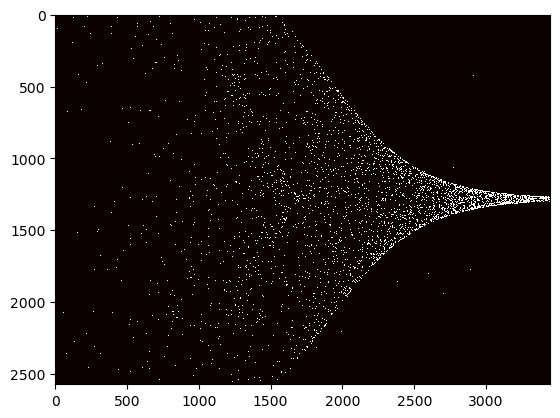

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


300000 rays received, 241455 incident on the first lens.
 --> 19.5 % of rays wasted!

rf size expected: [241455. 241455.]
rf after clearing nan's: [241125. 241125.]
(241125,) (241125,)


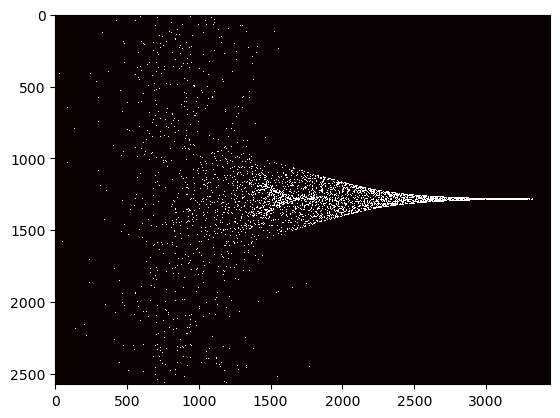

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf, L = 50)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


300000 rays received, 195055 incident on the first lens.
 --> 35.0 % of rays wasted!

rf size expected: [195055. 195055.]
rf after clearing nan's: [195055. 195055.]
(195055,) (195055,)


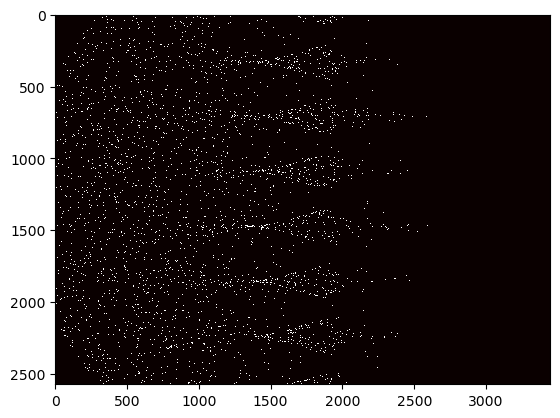

In [ ]:
shadowgrapher = diag.Shadowgraphy(lwl, rf)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


300000 rays received, 195055 incident on the first lens.
 --> 35.0 % of rays wasted!

rf size expected: [195055. 195055.]
rf after clearing nan's: [125352. 125352.]
(125352,) (125352,)


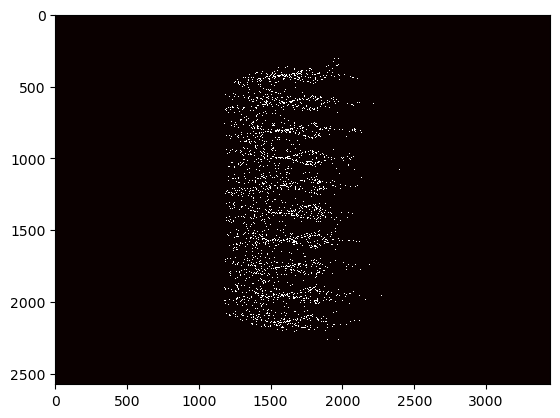

In [ ]:
schlierener = diag.Schlieren(lwl, rf)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))